In [1]:
# Initialize Notebook
from IPython.core.display import HTML,Image
#%run ../library/v1.0.5/init.ipy
HTML('''<script> code_show=true;  function code_toggle() {  if (code_show){  $('div.input').hide();  } else {  $('div.input').show();  }  code_show = !code_show }  $( document ).ready(code_toggle); </script> <form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [2]:
cd ~/projects/exSEEK_training/

/home/chenxupeng/projects/exSEEK_training


In [3]:
import gc, argparse, sys, os, errno
from functools import reduce
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve,roc_auc_score,auc,precision_recall_curve,average_precision_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

# load plotting functions
embed pdf; std_plot; display dataframe

In [4]:
def embed_pdf_figure(width='640', height='480', title='Image'):
    data = BytesIO()
    plt.savefig(data, format='pdf', metadata={'Title': title})
    data = data.getvalue()
    data = 'data:application/pdf;base64,'+ str(b64encode(data), encoding='utf-8')
    display(HTML('<object width="{}" height="{}" data="{}" download="{}.pdf"></object>'.format(
        width, height, data, title)))
    plt.close()
    

from matplotlib.backends.backend_pdf import PdfPages, PdfFile
from IPython.display import HTML, display, FileLink
from base64 import b64encode, b64decode
from io import StringIO, BytesIO
from contextlib import contextmanager

@contextmanager
def embed_pdf_pages(width=960, height=480, title='Image'):
    data = BytesIO()
    try:
        pdf = PdfPages(data, metadata={'Title': title})
        yield pdf
    finally:
        pdf.close()
        data = data.getvalue()
        data = 'data:application/pdf;base64,'+ str(b64encode(data), encoding='utf-8')
        display(HTML('<object width="{}" height="{}" data="{}"></object>'.format(width, height, data)))
        plt.close()

@contextmanager
def embed_pdf_data(width=640, height=480, title='Image'):
    try:
        data = BytesIO()
        yield data
    finally:
        data = data.getvalue()

        data = 'data:application/pdf;base64,'+ str(b64encode(data), encoding='utf-8')
        display(HTML('<object width="{}" height="{}" data="{}"></object>'.format(width, height, data)))
        plt.close()
        
def gradient_func(val):
    return '<span style="background: linear-gradient(90deg, #d65f5f {0}%, transparent 0%)">{0:.3f}</span>'.format(val)

def display_dataframe(df, filename=None, encoding='utf-8', format='csv', type='button',gradientfunc=False, **kwargs):
    #display(df)
    #if isinstance(df, pd.DataFrame):
    #    display(df.style.set_caption(filename))
    #else:
    if gradientfunc == False:
        display(df.style.set_caption(filename))    
    else:
        display(df.style.format(gradient_func).set_caption(filename)) 
    if filename is None:
        filename = "dataframe"
    if format == 'csv':
        data = df.to_csv(**kwargs)
        mime_type = 'text/csv'
        filename = filename + '.csv'
    elif format == 'tsv':
        data = df.to_csv(**kwargs)
        mime_type = 'text/plain'
        filename = filename + '.txt'
    else:
        raise ValueError('unknown file format: {}'.format(format))
    data = 'data:{mime_type};base64,'.format(mime_type=mime_type) + str(b64encode(bytes(data, encoding=encoding)), encoding=encoding)
    if type == 'hyperlink':
        display(HTML('<a href=" " download={filename} target="_blank">{filename}</a >'.format(
            mime_type=mime_type, filename=filename, data=data)))
    elif type == 'button':
        button_id = 'button_{}'.format(np.random.randint(1000000000))
        display(HTML(r'<input type="button" id="{0}" value="Download">'.format(button_id)))
        display(HTML('''<script>
    document.getElementById("{button_id}").addEventListener("click", function(event){{
        var filename = "{filename}";
        var data = "{data}";
        const element = document.createElement('a');
        element.setAttribute('href', data);
        element.setAttribute('download', filename);
        element.style.display = 'none';
        document.body.appendChild(element);
        element.click();
        document.body.removeChild(element);
    }});
</script>'''.format(button_id=button_id, filename=filename, data=data)))
        
def log_transfrom(data,small=0.01):
    return np.log2(data+small)

In [5]:
fontsize = 6.5
fontscale = 1
fontweight =  'normal'
fonttitle = {'family':'Arial',
                  'weight' : fontweight, 
                  'size' : fontsize*fontscale}
fontlabel = {'family':'Arial',
                  'weight' : fontweight, 
                  'size' : fontsize*fontscale}
fontticklabel = {'family':'Arial',
                  'weight' : fontweight, 
                  'size' : fontsize*fontscale}
fontlegend = {'family':'Arial',
                  'weight' : fontweight, 
              #'linewidth':0.5,
                  'size' : fontsize*fontscale}
fontcbarlabel = {'family':'Arial',
                 'weight' : fontweight, 
                 #'Rotation' : 270,
                 #'labelpad' : 25,
                 'size' : fontsize*fontscale}
fontcbarticklabel = {'family':'Arial',#Helvetica
                 'weight' : fontweight, 
                 'size' : (fontsize-1)*fontscale}

def std_plot(ax,xlabel=None,ylabel=None,title=None,
             legendtitle=None,bbox_to_anchor=None,
             labelspacing=0.2,borderpad=0.2,handletextpad=0.2,legendsort=False,markerscale=None,
             xlim=None,ylim=None,
             xbins=None,ybins=None,
             cbar=None,cbarlabel=None,
             moveyaxis=False,sns=False,left=True,rotation=None,xticklabel=None,legendscale=True,h=None,l=None,row=1,legend_adj=True,**kwards):
        # height = 2 font = 6.5
    def autoscale(fig):
        if isinstance(fig,matplotlib.figure.Figure):
            width,height = fig.get_size_inches()
        elif isinstance(fig,matplotlib.axes.Axes):
            width,height = fig.figure.get_size_inches()
        fontscale = height/(2*row)
        if width/fontscale > 8:
            warnings.warn("Please reset fig's width. When scaling the height to 2 in, the scaled width '%.2f' is large than 8"%(width/fontscale),UserWarning)
        return fontscale
    
    class fontprop:
        def init(self,fonttitle=None,fontlabel=None,fontticklabel=None,fontlegend=None,fontcbarlabel=None,fontcbarticklabel=None):
            self.fonttitle = fonttitle
            self.fontlabel = fontlabel
            self.fontticklabel = fontticklabel
            self.fontlegend = fontlegend
            self.fontcbarlabel = fontcbarlabel
            self.fontcbarticklabel = fontcbarticklabel
        def update(self,fontscale):
            self.fonttitle['size'] = self.fonttitle['size']*fontscale
            self.fontlabel['size'] = self.fontlabel['size']*fontscale
            self.fontticklabel['size'] = self.fontticklabel['size']*fontscale
            self.fontlegend['size'] = self.fontlegend['size']*fontscale
            self.fontcbarlabel['size'] = self.fontcbarlabel['size']*fontscale
            self.fontcbarticklabel['size'] = self.fontcbarticklabel['size']*fontscale
        def reset(self,fontscale):
            self.fonttitle['size'] = self.fonttitle['size']/fontscale
            self.fontlabel['size'] = self.fontlabel['size']/fontscale
            self.fontticklabel['size'] = self.fontticklabel['size']/fontscale
            self.fontlegend['size'] = self.fontlegend['size']/fontscale
            self.fontcbarlabel['size'] = self.fontcbarlabel['size']/fontscale
            self.fontcbarticklabel['size'] = self.fontcbarticklabel['size']/fontscale
    fontscale = autoscale(ax)
    font = fontprop()
    font.init(fonttitle,fontlabel,fontticklabel,fontlegend,fontcbarlabel,fontcbarticklabel)
    font.update(fontscale)
    
    pyplot.draw()
    #plt.figure(linewidth=30.5)
    if xlim is not None:  
        ax.set(xlim=xlim)
    if ylim is not None:
        ax.set(ylim=ylim)
    #pyplot.draw()
    if xbins is not None:
        locator = MaxNLocator(nbins=xbins)
        locator.set_axis(ax.xaxis)
        ax.set_xticks(locator())
    if ybins is not None:
        locator = MaxNLocator(nbins=ybins)
        locator.set_axis(ax.yaxis)
        ax.set_yticks(locator())
    pyplot.draw()
    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel(xlabel,fontdict = font.fontlabel,labelpad=(fontsize-1)*fontscale)
    ax.set_ylabel(ylabel,fontdict = font.fontlabel,labelpad=(fontsize-1)*fontscale)
    if (rotation is not None) & (xticklabel is not None) :
        ax.set_xticklabels(xticklabel,fontticklabel,rotation=rotation)
    elif (xticklabel is not None) &(rotation is None):
        ax.set_xticklabels(xticklabel,fontticklabel)
    elif (xticklabel is None) &(rotation is None):
        ax.set_xticklabels(ax.get_xticklabels(),fontticklabel)
    elif (rotation is not None) & (xticklabel is None):
        ax.set_xticklabels(ax.get_xticklabels(),fontticklabel,rotation=rotation)
    ax.set_yticklabels(ax.get_yticklabels(),font.fontticklabel)

    if moveyaxis is True:
        #fontticklabel 
        ax.spines['left'].set_position(('data',0))
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(not left)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_linewidth(0.5*fontscale)
    ax.spines['bottom'].set_linewidth(0.5*fontscale)
    ax.spines['left'].set_linewidth(0.5*fontscale)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
    
    ax.tick_params(direction='out', pad=2*fontscale,width=0.5*fontscale)
    #ax.spines['bottom']._edgecolor="#000000"
    #ax.spines['left']._edgecolor="#000000"
    if title is not None:
        ax.set_title(title,fontdict = font.fonttitle)
    if legendscale is True:
        if (h is None)&(l is None):
            legend = ax.legend(prop=font.fontlegend,
                  bbox_to_anchor=bbox_to_anchor,
                  labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,markerscale=markerscale,**kwards)
        else:
            legend = ax.legend(h,l,prop=font.fontlegend,
                  bbox_to_anchor=bbox_to_anchor,
                  labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                  edgecolor="#000000",fancybox=False,markerscale=markerscale,**kwards)
    if legendtitle is not None:
        #if legendloc is None:
        #    legendloc="best"
        legend = ax.legend(title=legendtitle,prop=font.fontlegend,
                      bbox_to_anchor=bbox_to_anchor,
                      labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      edgecolor="#000000",fancybox=False,markerscale=markerscale,**kwards)
        ax.legend_.get_frame()._linewidth=0.5*fontscale
        legend.get_title().set_fontweight('normal')
        legend.get_title().set_fontsize(fontscale*fontsize)
        if legendsort is True:
            # h: handle l:label
            h,l = ax.get_legend_handles_labels()
            l,h = zip(*sorted(zip(l,h), key=lambda t: int(t[0]))) 
            legend = ax.legend(h,l,title=legendtitle,prop=font.fontlegend,
                      bbox_to_anchor=bbox_to_anchor,
                      labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      edgecolor="#000000",fancybox=False,markerscale=markerscale,**kwards)
            ax.legend_.get_frame()._linewidth=0.5*fontscale
            legend.get_title().set_fontweight('normal')
            legend.get_title().set_fontsize(fontscale*fontsize)
        if sns is True:
            h,l = ax.get_legend_handles_labels()
            #l,h = zip(*sorted(zip(l,h), key=lambda t: int(t[0]))) 
            legend = ax.legend(h[1:],l[1:],title=legendtitle,prop=font.fontlegend,
                      bbox_to_anchor=bbox_to_anchor,
                      labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      edgecolor="#000000",fancybox=False,markerscale=markerscale,**kwards)
            ax.legend_.get_frame()._linewidth=0.5*fontscale
            legend.get_title().set_fontweight('normal')
            legend.get_title().set_fontsize(fontscale*fontsize)
    elif legend_adj is True:
        legend = ax.legend(handles=h,labels=l,title=legendtitle,prop=font.fontlegend,
                      bbox_to_anchor=bbox_to_anchor,
                      labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      edgecolor="#000000",fancybox=False,markerscale=markerscale,**kwards)
        ax.legend_.get_frame()._linewidth=0.5*fontscale
        legend.get_title().set_fontweight('normal')
        legend.get_title().set_fontsize(fontscale*fontsize)

    if cbar is not None:
        #locator, formatter = cbar._get_ticker_locator_formatter()
        #ticks, ticklabels, offset_string = cbar._ticker(locator, formatter)
        #cbar.ax.spines['top'].set_visible(False)
        #cbar.ax.spines['right'].set_visible(False)
        #cbar.ax.spines['bottom'].set_visible(False)
        #cbar.ax.spines['left'].set_visible(False)
        cbar.ax.tick_params(direction='out', pad=3*fontscale,width=0*fontscale,length=0*fontscale)
        cbar.set_label(cbarlabel,fontdict = font.fontcbarlabel,Rotation=270,labelpad=fontscale*(fontsize+1))
        cbar.ax.set_yticks(cbar.ax.get_yticks())
        cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),font.fontcbarticklabel)
    font.reset(fontscale)
    return ax

In [6]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
#force reload of the module
reload(figure_template)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot

# Python

In [7]:
# use a tab
for i in range(3):
    print(i)
# use 2 spaces
for i in range(3):
  print(i)
# use 4 spaces
for i in range(3):
    print(i)

0
1
2
0
1
2
0
1
2


In [8]:
print("The \n makes a new line")
print("The \t is a tab")
print('I\'m going to the movies')

The 
 makes a new line
The 	 is a tab
I'm going to the movies


In [9]:
firstVariable = 'Hello World!'
print(firstVariable)
print(firstVariable.lower())
print(firstVariable.upper())
print(firstVariable.title())

Hello World!
hello world!
HELLO WORLD!
Hello World!


In [10]:
print (1+1)
print (130-2.0)
print (126/3)
print (2*3)
print (2**3)
print (10%3)

2
128.0
42.0
6
8
1


In [11]:
# Defining a list
z = [3, 7, 4, 2]

In [12]:
print (z[0])

print (z[-1])

print (z[0:2])

3
2
[3, 7]


In [13]:
x = [3, 7, 2, 11, 8, 10, 4]
y = ['Steve', 'Rachel', 'Michael', 'Adam', 'Monica', 'Jessica', 'Lester']
x.append(3)
y.append('James')
print(x)
print(y)

[3, 7, 2, 11, 8, 10, 4, 3]
['Steve', 'Rachel', 'Michael', 'Adam', 'Monica', 'Jessica', 'Lester', 'James']


## numpy and pandas

### numpy
http://cs231n.github.io/python-numpy-tutorial/

In [14]:
import numpy as np

a = np.array([1, 2, 3])   # Create a rank 1 array
print(type(a))            # Prints "<class 'numpy.ndarray'>"
print(a.shape)            # Prints "(3,)"
print(a[0], a[1], a[2])   # Prints "1 2 3"
a[0] = 5                  # Change an element of the array
print(a)                  # Prints "[5, 2, 3]"

b = np.array([[1,2,3],[4,5,6]])    # Create a rank 2 array
print(b.shape)                     # Prints "(2, 3)"
print(b[0, 0], b[0, 1], b[1, 0])   # Prints "1 2 4"

<class 'numpy.ndarray'>
(3,)
1 2 3
[5 2 3]
(2, 3)
1 2 4


In [15]:
a = np.zeros((2,2))   # Create an array of all zeros
print(a)              # Prints "[[ 0.  0.]
                      #          [ 0.  0.]]"

b = np.ones((1,2))    # Create an array of all ones
print(b)              # Prints "[[ 1.  1.]]"

c = np.full((2,2), 7)  # Create a constant array
print(c)               # Prints "[[ 7.  7.]
                       #          [ 7.  7.]]"

d = np.eye(2)         # Create a 2x2 identity matrix
print(d)              # Prints "[[ 1.  0.]
                      #          [ 0.  1.]]"

e = np.random.random((2,2))  # Create an array filled with random values
print(e)                     # Might print "[[ 0.91940167  0.08143941]
                             #               [ 0.68744134  0.87236687]]"

[[0. 0.]
 [0. 0.]]
[[1. 1.]]
[[7 7]
 [7 7]]
[[1. 0.]
 [0. 1.]]
[[0.31522878 0.552364  ]
 [0.20228974 0.77223491]]


In [16]:
np.eye(15)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.

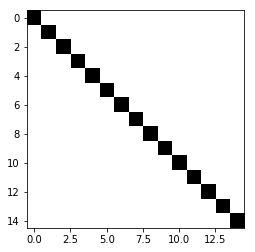

In [17]:
imshow(np.eye(15),cmap=cm.gray_r)

In [18]:
np.random.random(100).reshape(10,10).shape

(10, 10)

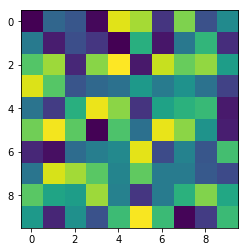

In [19]:
imshow(np.random.random(100).reshape(10,10))

### Pandas
https://github.com/adeshpande3/Pandas-Tutorial/blob/master/Pandas%20Tutorial.ipynb

In [20]:
df = pd.read_csv('data/RegularSeasonCompactResults.csv')

In [21]:
df.shape

(145289, 8)

In [22]:
df.head(10)

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
5,1985,25,1218,79,1337,78,H,0
6,1985,25,1228,64,1226,44,N,0
7,1985,25,1242,58,1268,56,N,0
8,1985,25,1260,98,1133,80,H,0
9,1985,25,1305,97,1424,89,H,0


In [23]:
df.tail(3)

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
145286,2016,132,1246,82,1401,77,N,1
145287,2016,132,1277,66,1345,62,N,0
145288,2016,132,1386,87,1433,74,N,0


In [24]:
df.shape

(145289, 8)

In [25]:
df.describe()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Numot
count,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000,145289.000000
mean,2001.574834,75.223816,1286.720646,76.600321,1282.864064,64.497009,0.044387
std,9.233342,33.287418,104.570275,12.173033,104.829234,11.380625,0.247819
min,1985.000000,0.000000,1101.000000,34.000000,1101.000000,20.000000,0.000000
25%,1994.000000,47.000000,1198.000000,68.000000,1191.000000,57.000000,0.000000
50%,2002.000000,78.000000,1284.000000,76.000000,1280.000000,64.000000,0.000000
75%,2010.000000,103.000000,1379.000000,84.000000,1375.000000,72.000000,0.000000
max,2016.000000,132.000000,1464.000000,186.000000,1464.000000,150.000000,6.000000


In [26]:
df['Wscore']

0          81
1          77
2          63
3          70
4          86
5          79
6          64
7          58
8          98
9          97
10        103
11         75
12         91
13         70
14         87
15         65
16         92
17         65
18         58
19         50
20         47
21         55
22         76
23         59
24         79
25        106
26         95
27         79
28         64
29         76
         ... 
145259     69
145260     72
145261     64
145262     77
145263     57
145264     68
145265     81
145266     64
145267     81
145268     93
145269     74
145270     64
145271     55
145272     61
145273     88
145274     76
145275     69
145276     82
145277     54
145278     82
145279     80
145280     71
145281     82
145282     76
145283     62
145284     70
145285     72
145286     82
145287     66
145288     87
Name: Wscore, Length: 145289, dtype: int64

In [27]:
df['Wscore'].max(), df['Wscore'].mean(), df['Wscore'].argmax()

(186, 76.60032074004226, 24970)

In [28]:
df['Season'].value_counts()

2016    5369
2014    5362
2015    5354
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
2002    4555
2000    4519
2001    4467
1999    4222
1998    4167
1997    4155
1992    4127
1991    4123
1996    4122
1995    4077
1994    4060
1990    4045
1989    4037
1993    3982
1988    3955
1987    3915
1986    3783
1985    3737
Name: Season, dtype: int64

In [29]:
np.unique(df['Season'],return_counts=True)

(array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
        1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]),
 array([3737, 3783, 3915, 3955, 4037, 4045, 4123, 4127, 3982, 4060, 4077,
        4122, 4155, 4167, 4222, 4519, 4467, 4555, 4616, 4571, 4675, 4757,
        5043, 5163, 5249, 5263, 5246, 5253, 5320, 5362, 5354, 5369]))

In [30]:
df['Wscore'].argmax()

24970

In [31]:
df.iloc[df['Wscore'].argmax(),:3]

Season    1991
Daynum      68
Wteam     1258
Name: 24970, dtype: object

In [32]:
df.loc[np.where(df['Wscore']==186)[0], 'Lscore']

24970    140
Name: Lscore, dtype: int64

In [33]:
df.sort_values('Lscore').head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
100027,2008,66,1203,49,1387,20,H,0
49310,1997,66,1157,61,1204,21,H,0
89021,2006,44,1284,41,1343,21,A,0
85042,2005,66,1131,73,1216,22,H,0
103660,2009,26,1326,59,1359,22,H,0


In [34]:
df[(df['Wscore'] > 150) & (df['Lscore'] < 100)]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
12046,1988,40,1328,152,1147,84,H,0
12355,1988,52,1328,151,1173,99,N,0
25656,1991,84,1106,151,1212,97,H,0
28687,1992,54,1261,159,1319,86,H,0
35023,1993,112,1380,155,1341,91,A,0
52600,1998,33,1395,153,1410,87,H,0


In [35]:
df.groupby('Wteam')['Wscore'].mean().head()

Wteam
1101    78.111111
1102    69.893204
1103    75.839768
1104    75.825944
1105    74.960894
Name: Wscore, dtype: float64

In [36]:
df.groupby('Wteam')['Wloc'].value_counts().head(9)

Wteam  Wloc
1101   H        12
       A         3
       N         3
1102   H       204
       A        73
       N        32
1103   H       324
       A       153
       N        41
Name: Wloc, dtype: int64

In [37]:
df.values

array([[1985, 20, 1228, ..., 64, 'N', 0],
       [1985, 25, 1106, ..., 70, 'H', 0],
       [1985, 25, 1112, ..., 56, 'H', 0],
       ...,
       [2016, 132, 1246, ..., 77, 'N', 1],
       [2016, 132, 1277, ..., 62, 'N', 0],
       [2016, 132, 1386, ..., 74, 'N', 0]], dtype=object)

Text(0.5, 0, 'Points for Winning Team')

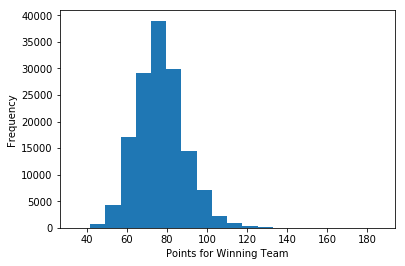

In [38]:
ax = df['Wscore'].plot.hist(bins=20)
ax.set_xlabel('Points for Winning Team')

#### qgrid filtering

In [39]:
!pip install qgrid

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [40]:
import numpy as np
import pandas as pd
import qgrid
randn = np.random.randn
df_types = pd.DataFrame({
    'A' : 1.,
    'B' : pd.Series(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09'],index=list(range(9)),dtype='datetime64[ns]'),
    'C' : pd.Series(randn(9),index=list(range(9)),dtype='float32'),
    'D' : np.array([3] * 9,dtype='int32'),
    'E' : pd.Categorical(["washington", "adams", "washington", "madison", "lincoln","jefferson", "hamilton", "roosevelt", "kennedy"]),
    'F' : ["foo", "bar", "buzz", "bippity","boppity", "foo", "foo", "bar", "zoo"] })
df_types['G'] = df_types['F'] == 'foo'
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True, 'boldIndex': True}, id='513ab688-35f8-4c53-81f3-0a240e530740', precision=5, show_toolbar=True)

In [41]:
qgrid_widget.get_changed_df()

,A,B,C,D,E,F,G
0,1.0,2013-01-01,0.532420,3,washington,foo,True
1,1.0,2013-01-02,-0.099736,3,adams,bar,False
2,1.0,2013-01-03,0.186100,3,washington,buzz,False
3,1.0,2013-01-04,-0.946474,3,madison,bippity,False
4,1.0,2013-01-05,-0.895556,3,lincoln,boppity,False
5,1.0,2013-01-06,-1.109674,3,jefferson,foo,True
6,1.0,2013-01-07,0.004341,3,hamilton,foo,True
7,1.0,2013-01-08,-0.422513,3,roosevelt,bar,False
8,1.0,2013-01-09,-0.094027,3,kennedy,zoo,False


### Matplotlib

In [42]:
x

[3, 7, 2, 11, 8, 10, 4, 3]

In [43]:
np.sin(x)

array([ 0.14112001,  0.6569866 ,  0.90929743, -0.99999021,  0.98935825,
       -0.54402111, -0.7568025 ,  0.14112001])

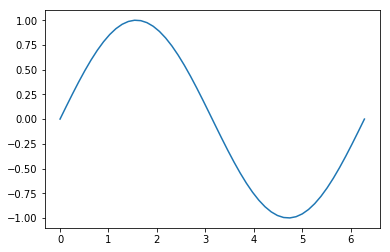

In [44]:
x = np.linspace(0, 2 * np.pi, 50)
plt.plot(x, np.sin(x))

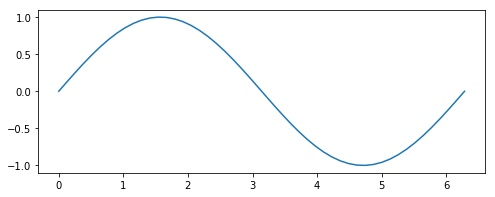

In [45]:
#use ax and figure
fig,ax=plt.subplots(figsize=(8,3))

x = np.linspace(0, 2 * np.pi, 50)
ax.plot(x, np.sin(x))

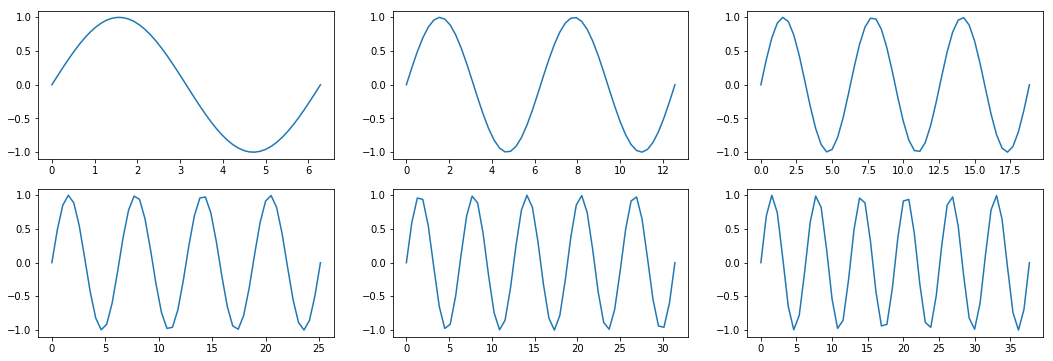

In [46]:
#use ax and figure
fig,ax=plt.subplots(2,3,figsize=(18,6))

for i in range(2):
    for j in range(3):
        x = np.linspace(0, 2 * np.pi * (i*3+j+1), 50)
        ax[i,j].plot(x, np.sin(x)) 

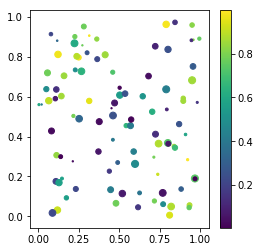

In [47]:
fig,ax=plt.subplots(figsize=(4,4))
x = np.random.rand(100)
y = np.random.rand(100)
size = np.random.rand(100) * 50
colour = np.random.rand(100)
scatter = ax.scatter(x, y, size, colour)
fig.colorbar(scatter)

(array([ 2.,  0.,  4.,  1.,  3.,  1.,  5.,  7.,  9., 12., 13., 13., 20.,
        22., 29., 30., 30., 45., 40., 42., 39., 51., 54., 44., 54., 53.,
        49., 40., 47., 53., 28., 28., 34., 15., 11., 22., 16.,  8.,  8.,
         5.,  2.,  5.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([-3.01918071, -2.89070873, -2.76223675, -2.63376477, -2.50529279,
        -2.3768208 , -2.24834882, -2.11987684, -1.99140486, -1.86293287,
        -1.73446089, -1.60598891, -1.47751693, -1.34904494, -1.22057296,
        -1.09210098, -0.963629  , -0.83515702, -0.70668503, -0.57821305,
        -0.44974107, -0.32126909, -0.1927971 , -0.06432512,  0.06414686,
         0.19261884,  0.32109083,  0.44956281,  0.57803479,  0.70650677,
         0.83497875,  0.96345074,  1.09192272,  1.2203947 ,  1.34886668,
         1.47733867,  1.60581065,  1.73428263,  1.86275461,  1.9912266 ,
         2.11969858,  2.24817056,  2.37664254,  2.50511452,  2.63358651,
         2.76205849,  2.89053047,  3.01900245,  3.14747444,

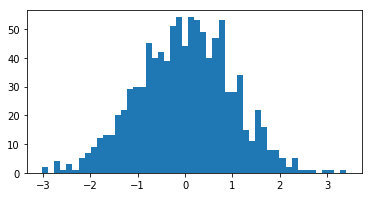

In [48]:
fig,ax=plt.subplots(figsize=(6,3))
x = np.random.randn(1000)
ax.hist(x, 50)

### Seaborn
use boxplot as an example
https://seaborn.pydata.org/generated/seaborn.boxplot.html

In [49]:
import numpy as np
import pandas as pd
np.random.seed(44)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Let us also get tableau colors we defined earlier:
tableau_20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
         (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
         (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
         (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
         (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scaling above RGB values to [0, 1] range, which is Matplotlib acceptable format:
for i in range(len(tableau_20)):
    r, g, b = tableau_20[i]
    tableau_20[i] = (r / 255., g / 255., b / 255.)

In [50]:
# Loading built-in Tips dataset:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


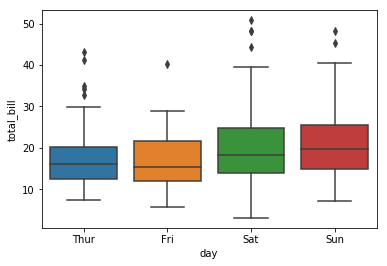

In [51]:
# Plotting basic Box Plot:
sns.boxplot(x="day", y="total_bill", data=tips)

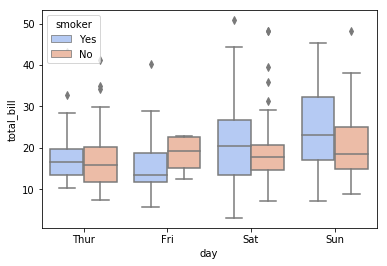

In [52]:
sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="coolwarm")

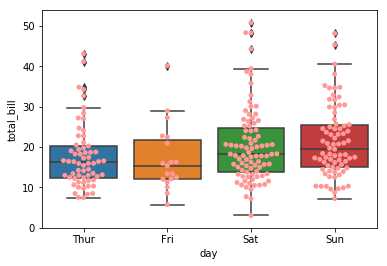

In [53]:
sns.boxplot(x="day", y="total_bill", data=tips)
sns.swarmplot(x="day", y="total_bill", data=tips, color=tableau_20[7])

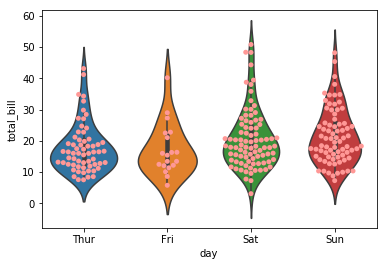

In [54]:
sns.violinplot(x="day", y="total_bill", data=tips)
sns.swarmplot(x="day", y="total_bill", data=tips, color=tableau_20[7])

# interactive plotting
It is useful to use ipywidgets to tune the parameters to get a perfect plot
https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html#Basic-interact

In [55]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [56]:
def f(x):
    return x

In [57]:
interact(f, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

<function __main__.f(x)>

In [58]:
interact(f, x=True)

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(x)>

In [59]:
interact(f, x='Hi there!')

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(x)>

fixed arguments

In [60]:
def h(p, q):
    return (p, q)

In [61]:
interact(h, p=5, q=fixed(20))

interactive(children=(IntSlider(value=5, description='p', max=15, min=-5), Output()), _dom_classes=('widget-interact',))

<function __main__.h(p, q)>

Slider

In [62]:
interact(f, x=widgets.IntSlider(min=-10,max=30,step=1,value=10))

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

<function __main__.f(x)>

In [63]:
interact(f, x=(-10,10,1))

interactive(children=(IntSlider(value=0, description='x', max=10, min=-10), Output()), _dom_classes=('widget-interact',))

<function __main__.f(x)>

In [64]:
widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
)

FloatSlider(value=7.5, continuous_update=False, description='Test:', max=10.0, orientation='vertical', readout_format='.1f')

In [65]:
widgets.IntProgress(
    value=9,
    min=0,
    max=10,
    step=1,
    description='Loading:',
    bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

IntProgress(value=9, bar_style='success', description='Loading:', max=10)

In [66]:
widgets.BoundedFloatText(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Text:',
    disabled=False
)

BoundedFloatText(value=7.5, description='Text:', max=10.0, step=0.1)

In [67]:
#Dropdown
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

In [68]:
widgets.RadioButtons(
    options=['holiday', 'work', 'study'],
#     value='pineapple',
    description='Pizza topping:',
    disabled=False
)

RadioButtons(description='Pizza topping:', options=('holiday', 'work', 'study'), value='holiday')

In [69]:
widgets.Select(
    options=['Linux', 'Windows', 'OSX'],
    value='OSX',
    # rows=10,
    description='OS:',
    disabled=False
)

Select(description='OS:', index=2, options=('Linux', 'Windows', 'OSX'), value='OSX')

In [70]:
widgets.SelectMultiple(
    options=['Ubuntu', 'CentOS','RedHat','Raspberry','Windows10', 'Mac OS Majove'],
    description='OS:',
)

SelectMultiple(description='OS:', options=('Ubuntu', 'CentOS', 'RedHat', 'Raspberry', 'Windows10', 'Mac OS Majove'), value=())

In [71]:
import datetime
dates = [datetime.date(2015,i,1) for i in range(1,13)]
options = [(i.strftime('%b'), i) for i in dates]
widgets.SelectionRangeSlider(
    options=options,
    index=(0,11),
    description='Months (2015)',
    disabled=False
)

SelectionRangeSlider(description='Months (2015)', index=(0, 11), options=(('Jan', datetime.date(2015, 1, 1)), ('Feb', datetime.date(2015, 2, 1)), ('Mar', datetime.date(2015, 3, 1)), ('Apr', datetime.date(2015, 4, 1)), ('May', datetime.date(2015, 5, 1)), ('Jun', datetime.date(2015, 6, 1)), ('Jul', datetime.date(2015, 7, 1)), ('Aug', datetime.date(2015, 8, 1)), ('Sep', datetime.date(2015, 9, 1)), ('Oct', datetime.date(2015, 10, 1)), ('Nov', datetime.date(2015, 11, 1)), ('Dec', datetime.date(2015, 12, 1))), value=(datetime.date(2015, 1, 1), datetime.date(2015, 12, 1)))

In [72]:
play = widgets.Play(
#     interval=10,
    value=50,
    min=0,
    max=100,
    step=1,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])

HBox(children=(Play(value=50, description='Press play'), IntSlider(value=0)))

In [73]:
widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

DatePicker(value=None, description='Pick a Date')

In [74]:
widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

ColorPicker(value='blue', description='Pick a color')

**based on the above things, you can create some fancy plotting...**

In [75]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import *

In [76]:
Xs = np.repeat(np.arange(0,100),100).reshape(-1,100).T.ravel()
Ys = np.repeat(np.arange(0,100),100).ravel()
Zs = np.random.random(10000).ravel()

def plot_3d_grid_surface(width,height,azim,elev,contextind,styind,featureind,savefig):
    fig = plt.figure(figsize=(width,height))
    p = 0.05
    f = -0.01

    def get_data(p):
        X = np.arange(-5, 5, 0.25)
        Y = np.arange(-5, 5, 0.25)
        X, Y = np.meshgrid(X, Y)
        R = np.sqrt(X**2 + Y**2)
        Z = np.sin(R)

        return X,Y,Z

    x, y, z = get_data(p)

    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    z_min, z_max = np.min(z), np.max(z)

    fig= plt.figure(figsize=(15, 10))


    ax = plt.axes(projection='3d')
    ax.tick_params(labelsize=8)
    #ax.view_init(azim=azim, elev=elev)
    #ax.plot_surface(x, y, z, rstride=10, cstride=10, alpha=1)
    ax.contourf(x, y, z, zdir='z', offset=-2, cmap=cm.coolwarm)

    surf = ax.plot_surface(x,y,z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)



    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)


    ax.set_xlabel('X')
    ax.set_xlim(x_min, x_max)
    ax.set_ylabel('Y')
    ax.set_ylim(y_min, y_max)
    ax.set_zlabel('Z')
    ax.set_zlim(-2, 1.01)
    
    ax.view_init(azim=azim,elev=elev)

interact(plot_3d_grid_surface,
    contextind=FloatSlider(min=0,max=3,step=1,value=2),
         styind=FloatSlider(min=0,max=2,step=1),
    width =FloatSlider(min=4,max=40,step=1,value=25),
         featureind=IntSlider(min=0,max=30,step=1,value=0),
    height= FloatSlider(min=4,max=30,step=1,value=16),
    azim= FloatSlider(min=0,max=180,step=2,value=45,continuous_update=False),
         savefig= RadioButtons(options=['show','save']),
    elev= FloatSlider(min=0,max=180,step=1,value=32,continuous_update=False,))

interactive(children=(FloatSlider(value=25.0, description='width', max=40.0, min=4.0, step=1.0), FloatSlider(value=16.0, description='height', max=30.0, min=4.0, step=1.0), FloatSlider(value=45.0, continuous_update=False, description='azim', max=180.0, step=2.0), FloatSlider(value=32.0, continuous_update=False, description='elev', max=180.0, step=1.0), FloatSlider(value=2.0, description='contextind', max=3.0, step=1.0), FloatSlider(value=0.0, description='styind', max=2.0, step=1.0), IntSlider(value=0, description='featureind', max=30), RadioButtons(description='savefig', options=('show', 'save'), value='show'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_3d_grid_surface(width, height, azim, elev, contextind, styind, featureind, savefig)>

# display dataframe, std_plot, pdf_figure...

In [77]:
import numpy as np
import pandas as pd
import qgrid
randn = np.random.randn
df_types = pd.DataFrame({
    'A' : 1.,
    'B' : pd.Series(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09'],index=list(range(9)),dtype='datetime64[ns]'),
    'C' : pd.Series(randn(9),index=list(range(9)),dtype='float32'),
    'D' : np.array([3] * 9,dtype='int32'),
    'E' : pd.Categorical(["washington", "adams", "washington", "madison", "lincoln","jefferson", "hamilton", "roosevelt", "kennedy"]),
    'F' : ["foo", "bar", "buzz", "bippity","boppity", "foo", "foo", "bar", "zoo"] })
df_types['G'] = df_types['F'] == 'foo'
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True, 'boldIndex': True}, id='6ae8a105-4b78-4109-9148-824572b1d9ec', precision=5, show_toolbar=True)

In [78]:
qgrid_widget.get_changed_df()

,A,B,C,D,E,F,G
0,1.0,2013-01-01,0.450178,3,washington,foo,True
1,1.0,2013-01-02,0.685630,3,adams,bar,False
2,1.0,2013-01-03,0.509629,3,washington,buzz,False
3,1.0,2013-01-04,2.133462,3,madison,bippity,False
4,1.0,2013-01-05,-0.136161,3,lincoln,boppity,False
5,1.0,2013-01-06,1.195330,3,jefferson,foo,True
6,1.0,2013-01-07,-0.998227,3,hamilton,foo,True
7,1.0,2013-01-08,0.109995,3,roosevelt,bar,False
8,1.0,2013-01-09,0.493986,3,kennedy,zoo,False


In [79]:
display_dataframe(qgrid_widget.get_changed_df(),filename='qgrid_widget_data')

,A,B,C,D,E,F,G
0,1,2013-01-01 00:00:00,0.450178,3,washington,foo,True
1,1,2013-01-02 00:00:00,0.68563,3,adams,bar,False
2,1,2013-01-03 00:00:00,0.509629,3,washington,buzz,False
3,1,2013-01-04 00:00:00,2.13346,3,madison,bippity,False
4,1,2013-01-05 00:00:00,-0.136161,3,lincoln,boppity,False
5,1,2013-01-06 00:00:00,1.19533,3,jefferson,foo,True
6,1,2013-01-07 00:00:00,-0.998227,3,hamilton,foo,True
7,1,2013-01-08 00:00:00,0.109995,3,roosevelt,bar,False
8,1,2013-01-09 00:00:00,0.493986,3,kennedy,zoo,False


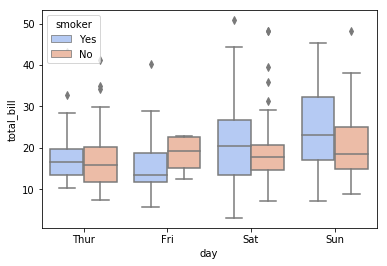

In [80]:
tips  = sns.load_dataset('tips')
sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="coolwarm")

```python
ax,xlabel,ylabel,title=None,
legendtitle=None,bbox_to_anchor=None,
labelspacing=1.2,borderpad=1,handletextpad=0.5,legendsort=False,markerscale=None,
xlim=None,ylim=None,
xbins=None,ybins=None,
cbar=None,cbarlabel=None,
moveyaxis=False,sns=False,left=True,rotation=None,xticklabel=None
```

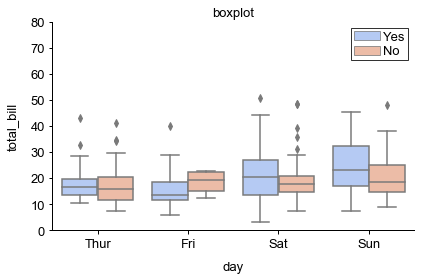

In [81]:
fig,ax=plt.subplots(figsize=(6,4))
sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="coolwarm",
           ax=ax)
ax = std_plot(ax=ax,xlabel='day',ylabel='total_bill',title='boxplot',
              ylim=[0,80])
fig.tight_layout()
#embed_pdf_figure()

# Basic plot
Now we try to use the following commands to get summary plot of exSEEK modules:
- mapping
- count matrix
- differetial expression

In [82]:
def interactive_config_settings(dataset,sequencing_type,classifier,value_change,example_cancer,reads_preprocess,stage_info,saveformat):
    if sequencing_type == 'short':
        exp_mx_name = 'mirna_and_domains_rna'
    elif sequencing_type =='long':
        exp_mx_name = 'featurecounts'
    elif sequencing_type =='domain_only':
        exp_mx_name = 'domains_long'
    elif sequencing_type =='transcript':
        exp_mx_name = 'transcript'
    elif sequencing_type =='transcript_small':
        exp_mx_name = 'transcript_small'
    elif sequencing_type =='transcript_long_bg':
        exp_mx_name = 'transcript_long_bg'
    return dataset,sequencing_type,classifier,value_change,exp_mx_name,example_cancer,reads_preprocess,stage_info,saveformat

widget =interactive(interactive_config_settings,
           dataset= ['lulab_hcc','scirep','exorbase','exosome_small','pico_3v3'],
           sequencing_type=['short','long','domain_only','transcript','transcript_small','transcript_long_bg'],
           classifier = ['random_forest','logistic_regression','linear_svm','decision_tree','logistic_regression_l1'],
           value_change = ['any','up','down'],
        example_cancer=['Normal-CRC','Normal-PAAD','Normal-PRAD','Normal-HCC'],
                   reads_preprocess=[True,False],
                   stage_info = ['No Stage','With Stage'],
                 saveformat=['.pdf','.eps'])  # if start from preprocessing
display(widget)


interactive(children=(Dropdown(description='dataset', options=('lulab_hcc', 'scirep', 'exorbase', 'exosome_small', 'pico_3v3'), value='lulab_hcc'), Dropdown(description='sequencing_type', options=('short', 'long', 'domain_only', 'transcript', 'transcript_small', 'transcript_long_bg'), value='short'), Dropdown(description='classifier', options=('random_forest', 'logistic_regression', 'linear_svm', 'decision_tree', 'logistic_regression_l1'), value='random_forest'), Dropdown(description='value_change', options=('any', 'up', 'down'), value='any'), Dropdown(description='example_cancer', options=('Normal-CRC', 'Normal-PAAD', 'Normal-PRAD', 'Normal-HCC'), value='Normal-CRC'), Dropdown(description='reads_preprocess', options=(True, False), value=True), Dropdown(description='stage_info', options=('No Stage', 'With Stage'), value='No Stage'), Dropdown(description='saveformat', options=('.pdf', '.eps'), value='.pdf'), Output()), _dom_classes=('widget-interact',))

In [83]:
dataset,sequencing_type,classifier_use,value_change,exp_mx_name,example_cancer,reads_preprocess,stage_info,saveformat = widget.result
dataset,sequencing_type,classifier_use,value_change,exp_mx_name,example_cancer,reads_preprocess,stage_info,saveformat

('lulab_hcc',
 'short',
 'random_forest',
 'any',
 'mirna_and_domains_rna',
 'Normal-CRC',
 True,
 'No Stage',
 '.pdf')

In [84]:
file_counts = 'output/'+dataset+'/summary/read_counts.txt'
file_length_path = 'output/'+dataset+'/stats/mapped_read_length_by_sample/'
file_length_path_insert = 'output/'+dataset+'/stats/mapped_insert_size_by_sample/'
#save_path = 'output/'+dataset+'/plots/'
save_path = '/home/chenxupeng/projects/exseek/supplement/'+dataset+'/'

if not os.path.exists(save_path ):
    os.makedirs(save_path )
    

In [85]:
#Get table
def get_counts_ratio_table(file_counts,sequencing_type='short'):
    df = pd.read_table(file_counts, index_col=0)
    if reads_preprocess == True:
        if sequencing_type == 'short':
            rna_types = [s.split('.')[0] for s in df.index.tolist() if s.endswith('.mapped')]
            rna_types = 'rRNA,miRNA,piRNA,Y_RNA,srpRNA,tRNA,snRNA,snoRNA,lncRNA,mRNA,tucpRNA,intron,promoter,enhancer,repeats,circRNA,other'.split(',')
            mapped_ratio = {}
            mapped_count = {}
            for sample_id in df.columns.tolist():
                mapped_ratio[sample_id] = {}
                mapped_count[sample_id] = {}
                clean_counts = float(df.loc['clean.unmapped', sample_id])
                for rna_type in rna_types:
                    mapped_ratio[sample_id][rna_type] = df.loc[rna_type + '.mapped', sample_id]/(
                        clean_counts - df.loc['other.unmapped', sample_id])
                    mapped_count[sample_id][rna_type] = df.loc[rna_type + '.mapped', sample_id]
                for region in ('promoter', 'enhancer', 'intron','repeats','circRNA'):
                    mapped_ratio[sample_id]['other'] -= mapped_ratio[sample_id][region]
                    mapped_count[sample_id]['other'] -= mapped_count[sample_id][region]
            mapped_count = pd.DataFrame.from_records(mapped_count)        
            mapped_ratio = pd.DataFrame.from_records(mapped_ratio)
            mapped_count = mapped_count.loc[rna_types, :]
            mapped_ratio = mapped_ratio.loc[rna_types, :]
            return df,mapped_count.T, mapped_ratio.T
        elif sequencing_type =='long':
            read_counts = pd.read_table(file_counts, index_col=0)
            read_counts = read_counts.T

            rna_types = read_counts.columns.tolist()
            rna_types.remove('clean')
            rna_types_included = list(rna_types)
            for rna_type in ('genome', 'rRNA'):
                rna_types_included.remove(rna_type)

            # percentage by clean reads
            #display(read_counts.style.set_caption('Read counts'))

            percent_by_clean = read_counts.loc[:, ['clean', 'rRNA', 'genome', 'circRNA']].copy()
            percent_by_clean = 100.0*percent_by_clean.div(percent_by_clean.loc[:, 'clean'], axis=0)
            percent_by_clean.drop(columns='clean', inplace=True)
            percent_by_clean['unmapped'] = 100 - percent_by_clean.sum(axis=1)
            #display(percent_by_clean.style.format(gradient_func).set_caption('Percentage by clean reads'))

            percent_by_mapped = read_counts.copy()
            percent_by_mapped = 100.0*percent_by_mapped.div(percent_by_mapped.loc[:, ['genome', 'circRNA']].sum(axis=1), axis=0)
            percent_by_mapped.drop(columns=['rRNA', 'genome', 'clean'], inplace=True)
            percent_by_mapped['other'] = 100.0 - percent_by_mapped.sum(axis=1)
            #display(percent_by_mapped.style.format(gradient_func).set_caption('Percentage by mapped reads'))
            return read_counts,percent_by_clean,percent_by_mapped
    else:
        if sequencing_type == 'short':
            pass
        elif sequencing_type =='long':
            read_counts = pd.read_table(file_counts, index_col=0)
            read_counts = read_counts.T

            rna_types = read_counts.columns.tolist()
            rna_types.remove('clean')
            rna_types_included = list(rna_types)
            for rna_type in ('genome', 'rRNA'):
                rna_types_included.remove(rna_type)

            # percentage by clean reads
            #display(read_counts.style.set_caption('Read counts'))

            percent_by_clean = read_counts.loc[:, ['clean', 'rRNA', 'genome', 'circRNA']].copy()
            percent_by_clean = 100.0*percent_by_clean.div(percent_by_clean.loc[:, 'clean'], axis=0)
            percent_by_clean.drop(columns='clean', inplace=True)
            percent_by_clean['unmapped'] = 100 - percent_by_clean.sum(axis=1)
            #display(percent_by_clean.style.format(gradient_func).set_caption('Percentage by clean reads'))

            percent_by_mapped = read_counts.copy()
            percent_by_mapped = 100.0*percent_by_mapped.div(percent_by_mapped.loc[:, ['genome', 'circRNA']].sum(axis=1), axis=0)
            percent_by_mapped.drop(columns=['rRNA', 'genome', 'clean'], inplace=True)
            percent_by_mapped['other'] = 100.0 - percent_by_mapped.sum(axis=1)
            #display(percent_by_mapped.style.format(gradient_func).set_caption('Percentage by mapped reads'))
            return read_counts,percent_by_clean,percent_by_mapped
        

In [86]:
def get_length_table(file_length_path,sequencing_type='short'):
    length_table = {}
    for i in os.listdir(file_length_path):
        if sequencing_type =='short':
            length_table[i] = pd.read_table(file_length_path+i,index_col=0).iloc[16:52]
        elif sequencing_type =='long':
            length_table[i] = pd.read_table(file_length_path+i,index_col=0).iloc[16:152]
    sample_names = np.array(os.listdir(file_length_path))
    length_table_sum = length_table[sample_names[0]]
    for i in sample_names[1:]:
        length_table_sum += length_table[i]
    return length_table_sum/length_table_sum.sum(axis=0)

In [87]:
if sequencing_type == 'short': 
    read_counts,table_count, table_ratio = get_counts_ratio_table(file_counts)
    length_table = get_length_table(file_length_path,sequencing_type=sequencing_type)
    rnanames=np.array(table_ratio.columns).astype('str')
elif sequencing_type == 'long': 
    read_counts,percent_by_clean,percent_by_mapped = \
                    get_counts_ratio_table(file_counts,sequencing_type='long')
    rnanames_1=np.array(percent_by_clean.columns).astype('str')
    rnanames_2=np.array(percent_by_mapped.columns).astype('str')
    length_table_1 = get_length_table(file_length_path,sequencing_type=sequencing_type)
    length_table_2 = get_length_table(file_length_path_insert,sequencing_type=sequencing_type)

In [88]:
if sequencing_type == 'short': 
    table_percent = table_ratio*100
    display_dataframe(table_count,filename='Mapped counts',gradientfunc=False)
    display_dataframe(table_percent,filename='Percentage by clean reads',gradientfunc=True)
elif sequencing_type == 'long': 
    display_dataframe(read_counts,filename='Read counts',gradientfunc=False)
    display_dataframe(percent_by_clean,filename='Percentage by clean reads',gradientfunc=True)
    display_dataframe(percent_by_mapped,filename='Percentage by mapped reads',gradientfunc=True)

,rRNA,miRNA,piRNA,Y_RNA,srpRNA,tRNA,snRNA,snoRNA,lncRNA,mRNA,tucpRNA,intron,promoter,enhancer,repeats,circRNA,other
17402567-B,1510902,24813195,226346,8076876,19065,214401,26195,123875,136753,77276,49462,63319,211316,343253,585035,1257,605242
249136-B,5919934,19028877,498510,7300522,22211,229186,100160,5611712,84373,118451,32544,27130,83902,825333,247448,3372,1261172
3497470-B,1328595,23274518,136302,5143336,14547,197875,19771,13706,165582,71252,63588,85266,128635,423164,598917,1165,895820
385247-B,4970007,21772376,356150,13548475,24316,206110,71353,2351586,92383,103906,52054,39758,128906,471177,397094,5381,822260
423976-B,1867200,8097308,163832,12801587,17092,184223,13758,195326,49688,98712,23221,35896,50952,149419,209249,2400,332927
497411-B,2301632,42333821,199732,9729864,18299,223140,36633,63709,153809,89206,39439,61501,142994,324591,557245,2442,618749
497497-B,481894,16869685,56940,7295329,9987,57135,208155,54431,73183,49086,21961,24849,155705,159272,402245,603,192106
498127-B,3372321,33473505,344113,20641518,35836,381891,43492,443366,279937,206852,62293,168524,326036,763641,1270992,4480,1587010
498187-B,5683539,30241686,368673,10702704,26681,329239,66781,2790418,130862,111066,32967,51205,131060,610571,471963,4269,990056
498221-B,755223,7976758,31683,3618553,10134,55847,58684,17588,81007,51786,27683,58015,113550,285355,498017,2243,560490


,rRNA,miRNA,piRNA,Y_RNA,srpRNA,tRNA,snRNA,snoRNA,lncRNA,mRNA,tucpRNA,intron,promoter,enhancer,repeats,circRNA,other
17402567-B,4.074,66.911,0.610,21.780,0.051,0.578,0.071,0.334,0.369,0.208,0.133,0.171,0.570,0.926,1.578,0.003,1.632
249136-B,14.301,45.969,1.204,17.636,0.054,0.554,0.242,13.557,0.204,0.286,0.079,0.066,0.203,1.994,0.598,0.008,3.047
3497470-B,4.080,71.477,0.419,15.795,0.045,0.608,0.061,0.042,0.509,0.219,0.195,0.262,0.395,1.300,1.839,0.004,2.751
385247-B,10.944,47.943,0.784,29.834,0.054,0.454,0.157,5.178,0.203,0.229,0.115,0.088,0.284,1.038,0.874,0.012,1.811
423976-B,7.686,33.332,0.674,52.697,0.070,0.758,0.057,0.804,0.205,0.406,0.096,0.148,0.210,0.615,0.861,0.010,1.370
497411-B,4.045,74.405,0.351,17.101,0.032,0.392,0.064,0.112,0.270,0.157,0.069,0.108,0.251,0.570,0.979,0.004,1.087
497497-B,1.845,64.604,0.218,27.938,0.038,0.219,0.797,0.208,0.280,0.188,0.084,0.095,0.596,0.610,1.540,0.002,0.736
498127-B,5.319,52.792,0.543,32.555,0.057,0.602,0.069,0.699,0.442,0.326,0.098,0.266,0.514,1.204,2.005,0.007,2.503
498187-B,10.776,57.337,0.699,20.292,0.051,0.624,0.127,5.291,0.248,0.211,0.063,0.097,0.248,1.158,0.895,0.008,1.877
498221-B,5.317,56.164,0.223,25.478,0.071,0.393,0.413,0.124,0.570,0.365,0.195,0.408,0.800,2.009,3.507,0.016,3.946


## pie plot of RNA ratio

In [89]:
from bokeh.io import output_file, show
from bokeh.palettes import Category20
from bokeh.plotting import figure
from bokeh.transform import cumsum

In [90]:
def plot_pie(data, rnanames):
    '''
    data: table_ratio
    rnanames: rna type names
    adjustment: merge RNA with small percent together
    '''
    x = np.array(rnanames)
    y = np.array(data.loc[:,x].mean())+10e-8
    z_ = np.array([x[i] + str(' {:.2f}'.format(y[i]*100)+'%') for i in range(y.shape[0])])
    z = np.array([float('{:.10f}'.format(y[i]*100)) for i in range(y.shape[0])])
    labels = rnanames
    dataframe = pd.DataFrame(np.concatenate((x.reshape(-1,1),z.reshape(-1,1),z_.reshape(-1,1)),axis=1))
    dataframe.columns=['rna','percent','label']
    dataframe["percent"] = pd.to_numeric(dataframe["percent"])
    dataframe['angle'] = dataframe['percent']/dataframe['percent'].sum() * 2*pi
    dataframe['color'] = Category20[len(x)]
    p = figure(plot_height=500,width=750, title="Pie Chart", toolbar_location=None,
               tools="hover", tooltips="@label", x_range=(-0.5, 1.0))
    p.wedge(x=0.14, y=1, radius=0.45,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="black", fill_color='color', legend="label", source=dataframe)
    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None
    show(p)
def plot_for_pie(sequencing_type=sequencing_type,by_sample=False):
    if by_sample:
        if sequencing_type == 'short': 
            for i in range(table_ratio.shape[0]):
                plot_pie(pd.DataFrame(table_ratio.iloc[i]).T, rnanames)
        elif sequencing_type == 'long': 
            for i in range(percent_by_mapped.shape[0]):
                plot_pie(pd.DataFrame(percent_by_mapped.iloc[i]/100.).T, rnanames_2)
    else:
        if sequencing_type == 'short': 
            plot_pie(table_ratio, rnanames)
        elif sequencing_type == 'long': 
            plot_pie(percent_by_mapped/100. , rnanames_2)
            plot_pie(percent_by_clean/100. , rnanames_1)
            
            
plot_for_pie(sequencing_type=sequencing_type,by_sample=False)

## boxplot of rna ratio

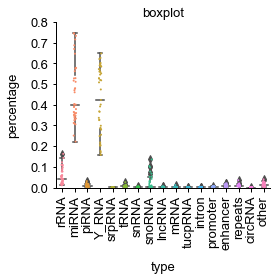

In [91]:
def plot_ratio_boxplot(data, rnanames, points_show = True, width=20, height=10, savefig=False):
    '''
    data: table_ratio
    rnanames: rna type names
    points_show: plot scatter points too
    '''
    fig, ax = plt.subplots(figsize=(width, height))
    sns.boxplot(data = data,ax=ax,boxprops=dict(alpha=.001),color='gray',width=0.65,saturation=0.01)
    if points_show:
        sns.stripplot(data = data,ax=ax,size=2, edgecolor='black')
    
    ax = std_plot(ax,'type','percentage','boxplot',ylim=[0,np.ceil(np.max(np.max(data))*10)/10],
                 xticklabel=rnanames,rotation=90,legendscale=False,legend_adj=False)

    fig.tight_layout()
    if savefig:
        fig.savefig(save_path+'rna_ratio_box_plot.eps', bbox_inches='tight')
    #embed_pdf_figure()

if sequencing_type == 'long': 
    plot_ratio_boxplot(percent_by_mapped/100, rnanames_2, points_show = True, 
               width=7, height=5, savefig=1)
else: 
    plot_ratio_boxplot(table_ratio, rnanames, points_show = True, width=4, height=4, savefig=1)

## line plot of rna length

In [92]:
def plot_length_line(data, rnanames, width=7, height=20, savefig=False):
    '''
    data: length_table
    rnanames: rna type names
    '''
    data=data.fillna(0)
    length = np.array(data.T)
    fig,ax=plt.subplots(length.shape[0],1,figsize=(width, height))
    for i in range(length.shape[0]):
        ax[i].plot(length[i],label=data.columns[i], color=Category20c[20][i],linewidth=1)
        ax[i].legend(loc='upper right')
        std_plot(ax[i],'','',ylim=[0,max(length[i])],ybins=5,row=length.shape[0])
        legend = ax[i].legend(prop=fontlegend,
              bbox_to_anchor=None,
              borderpad=1,
              edgecolor="#000000",fancybox=False)
        ax[i].legend_.get_frame()._linewidth=0.5
        legend.get_title().set_fontweight('normal')
        legend.get_title().set_fontsize(6.5)
    if savefig:
        fig.savefig(save_path+'rna_length_line_plot'+saveformat, bbox_inches='tight')
    fig.tight_layout()
    #embed_pdf_figure()

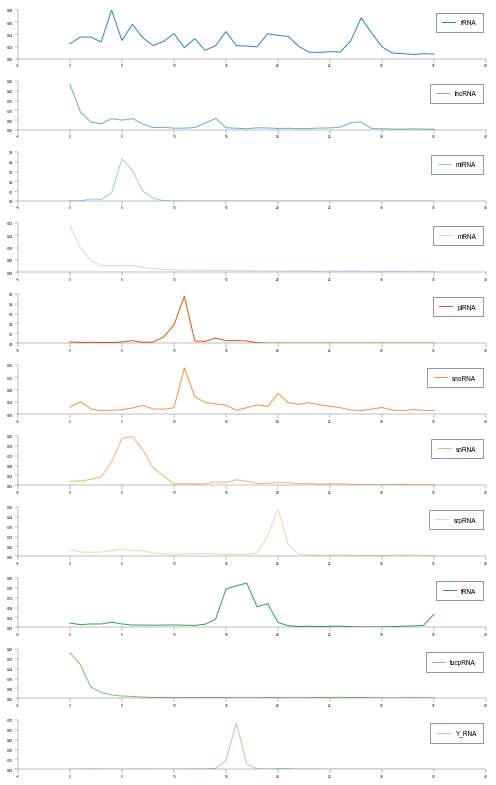

In [93]:
if sequencing_type == 'long': 
    plot_length_line(length_table_1, rnanames_1, width=7, height=length_table_1.shape[1], savefig=1)
    plot_length_line(length_table_2, rnanames_2, width=7, height=length_table_2.shape[1], savefig=1)
else: 
    plot_length_line(length_table, rnanames, width=7, height=length_table.shape[1], savefig=1)

## 3D barplot of rna length

In [94]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(data, width=7, height=5,  azim = 45, elev = 32,savefig=False):
    '''
    data: length_table
    '''
    #data = length_table
    data=data.fillna(0)
    fig = plt.figure(figsize=(width,height))
    ax1 = fig.gca(projection="3d")
    num = data.shape[1]
    count_ = data.shape[0]
    xpos = np.repeat(np.arange(1,count_+1),num).reshape(count_,-1).T.ravel()
    ypos = np.repeat(range(num),count_).ravel()
    num_elements = len(xpos)
    zpos = np.zeros(count_*num)
    dx = np.ones(count_*num)/5
    dy = np.ones(count_*num)/5
    dz = np.array(data.T).ravel()
    
    for i in range(num):
        ax1.bar3d(xpos[count_*i:count_*(i+1)], ypos[count_*i:count_*(i+1)], zpos[count_*i:count_*(i+1)],
                  dx[count_*i:count_*(i+1)], dy[count_*i:count_*(i+1)],dz[count_*i:count_*(i+1)], color=(np.array(Category20c[20]))[:num][i],alpha=0.9)
    plt.xticks(range(count_), [str(i+16) for i in range(count_)], size=6.5,color='red',weight='normal',family='Arial',rotation=-azim)
    ax1.set_yticks(range(num))
    ax1.set_yticklabels(data.columns, color='blue',weight='normal',family='Arial', size=6.5)
    fig.canvas.draw()
    ax1.set_zticks(ax1.get_zticks())
    ax1.set_zticklabels(ax1.get_zticklabels(),weight='normal',family='Arial', size=6.5)
    for color,tick in zip((Category20c[20])[:num],ax1.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    ax1.view_init(azim=azim,elev=elev)  
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('w')
    ax1.yaxis.pane.set_edgecolor('w')
    ax1.zaxis.pane.set_edgecolor('w')
    fig.tight_layout()
    if savefig:
        fig.savefig(save_path+'rna_length_3D_barplot'+saveformat, bbox_inches='tight')

In [ ]:
if sequencing_type == 'long': 
    plot_3d(length_table_1,width=7, height=5, savefig=1, azim = 45, elev = 32)
    embed_pdf_figure()
    plot_3d(length_table_2,width=7, height=5, savefig=1, azim = 45, elev = 32)
    embed_pdf_figure()
else:
    plot_3d(length_table,width=7, height=5, savefig=True, azim = 45, elev = 32)
    embed_pdf_figure()

## stack bar plot of rna counts and ratio

In [96]:
from matplotlib.colors import LinearSegmentedColormap
def stack_bar_ratio(table, ax,statistics = 'ratio',savefig=1):   
    
    table.plot(kind='bar', stacked=True,ax=ax,width=0.5,
                legend=True,colormap=matplotlib.colors.ListedColormap ( Category20c[20]))
    #ax.legend(bbox_to_anchor=(1,1),fontsize='large')#, loc="lower right",
    #ax.set_title('Stacked Bar plot',fontsize=40)
    #if savefig:
        #fig.savefig(save_path+statistics+'_stack_barplot'+saveformat, bbox_inches='tight')
    return ax

In [97]:
@contextmanager
def embed_pdf_data(width=640, height=480, title='Image'):
    try:
        data = BytesIO()
        yield data
    finally:
        data = data.getvalue()

        data = 'data:application/pdf;base64,'+ str(b64encode(data), encoding='utf-8')
        display(HTML('<object width="{}" height="{}" data="{}"></object>'.format(width, height, data)))
        plt.close()

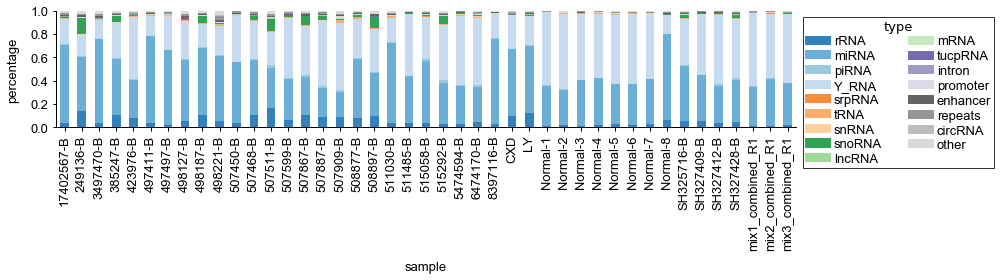

In [98]:
fig,ax=plt.subplots(figsize=(14,4))
if sequencing_type == 'long': 
    ax = stack_bar_ratio(percent_by_mapped/100.,ax=ax)
else:
    ax = stack_bar_ratio(table_ratio,ax=ax)

std_plot(ax,'sample','percentage',legendtitle='type',legendsort=False,ylim=[0,1],bbox_to_anchor=(1,1),borderpad=0.2,ncol=2)
fig.tight_layout()
#with embed_pdf_data(title='Clustermap') as data:
  #  fig.savefig(data, format='pdf')
fig.savefig(save_path+'rna_ratio_stack_barplot.eps')
#embed_pdf_figure()


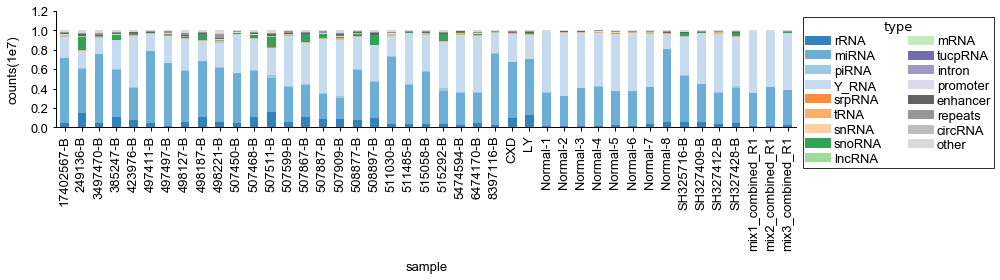

In [28]:
fig,ax=plt.subplots(figsize=(14,4))
    
if sequencing_type == 'long': 
    ax = stack_bar_ratio(percent_by_mapped/100,ax=ax)
else:
    ax = stack_bar_ratio(table_ratio,ax=ax)

std_plot(ax,'sample','counts(1e7)',legendtitle='type',legendsort=False,bbox_to_anchor=(1,1),borderpad=0.2,ncol=2)
fig.tight_layout()
#embed_pdf_figure()
fig.savefig(save_path+'_stack_barplot'+saveformat, bbox_inches='tight')

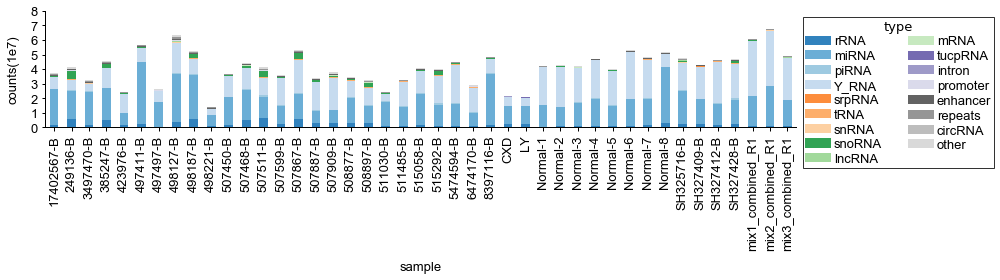

In [25]:
fig,ax=plt.subplots(figsize=(14,4))
    
if sequencing_type == 'long': 
    ax = stack_bar_ratio(read_counts,ax=ax)
else:
    ax = stack_bar_ratio(table_count,ax=ax)

std_plot(ax,'sample','counts(1e7)',legendtitle='type',legendsort=False,bbox_to_anchor=(1,1),borderpad=0.2,ncol=2)
fig.tight_layout()
#embed_pdf_figure()

## bar plot of RNA by sample

In [99]:
def plot_bar_by_rna(fig,ax,table,rnaname,savefig=1, statistics = 'ratio',height = 4, width=20):
    '''
    table: ratio or count table, rows are rna type
    statistics: ratio or count
    '''
    table = table.T
    count = np.array(table[table.index ==rnaname]).ravel()
    #fig,ax=plt.subplots(1,figsize=(width,height))
    counttable =  pd.DataFrame(np.concatenate((np.arange(1,table.shape[1]+1).reshape(-1,1),
                count[np.argsort(-count)].reshape(-1,1)),axis=1),columns=['sample',statistics])
    
    sns.barplot(ax=ax,x='sample',y=statistics,data = counttable,color=Category20c[20][np.random.randint(0,20)],alpha=1)
    ax.set_xticks(np.arange(0,table.shape[1],5))
    ax.set_xticklabels(np.arange(0,table.shape[1],5))
    ax.set_title(statistics+' of '+rnaname,fontsize=15)
    if savefig:
        fig.savefig(save_path+'sample_'+rnaname+'_'+statistics+'_bar_plot'+saveformat, bbox_inches='tight')
        

In [100]:
def plot_bar_by_rna_total(table,datatype='ratio'):
    fignum= table.columns.shape[0]
    fig,ax=plt.subplots(fignum ,1,figsize=(7 , 24 ))
    for i in range(fignum):
        plot_bar_by_rna(fig,ax[i],table,table.columns[i],statistics = datatype)
        std_plot(ax[i],'sample','ratio',datatype+' of '+table.columns[i])
    fig.tight_layout()

if sequencing_type == 'long': 
    plot_bar_by_rna_total(percent_by_mapped/100.,datatype='ratio')
else: 
    plot_bar_by_rna_total(table_ratio,datatype='ratio')

embed_pdf_figure()

if sequencing_type == 'long': 
    plot_bar_by_rna_total(percent_by_mapped/100.,datatype='count')
else: 
    plot_bar_by_rna_total(table_ratio,datatype='count')


embed_pdf_figure()

## FastQC

In [101]:
summary = pd.read_table('output/'+dataset+'/summary/fastqc.txt', sep='\t')
qc_status = summary.iloc[:, 9:]
qc_status.fillna('NA')
qc_status = qc_status.astype('str')
sample_ids = summary.sample_id
sections = qc_status.columns.values
def style_func(val):
    status, row, col = val.split('|')
    row, col = int(row), int(col)
    color = {'pass': 'green', 'fail': 'red', 'warn': 'orange'}.get(status, 'gray')
    return '<a href="../output/'+dataset+'/fastqc/{sample_id}_fastqc.html#M{section}" style="color: {color}">{status}</a>'.format(
        sample_id=sample_ids[row], color=color, status=status, section=col + 1)

pd.DataFrame(qc_status.values \
             + '|' + np.arange(qc_status.shape[0]).astype('str')[:, np.newaxis] \
             + '|' + np.arange(qc_status.shape[1]).astype('str')[np.newaxis, :],
             index=qc_status.index, columns=qc_status.columns) \
    .style.format(style_func)

,Basic Statistics,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content
0,pass,warn,warn,pass,fail,fail,pass,pass,fail,fail,fail
1,pass,fail,warn,pass,fail,fail,pass,pass,fail,fail,fail
2,pass,fail,warn,pass,fail,fail,pass,pass,fail,fail,fail
3,pass,fail,pass,pass,fail,fail,pass,pass,fail,fail,fail
4,pass,fail,warn,warn,fail,warn,pass,pass,fail,fail,fail
5,pass,fail,fail,pass,fail,fail,pass,pass,fail,fail,fail
6,pass,fail,pass,pass,fail,warn,pass,pass,fail,fail,fail
7,pass,fail,pass,pass,fail,fail,pass,pass,fail,fail,fail
8,pass,fail,pass,pass,fail,fail,pass,pass,fail,fail,fail
9,pass,fail,pass,pass,fail,fail,pass,pass,fail,fail,fail


## Sample QC
use PCA and tSNE to visualize outliters

In [102]:
original_mx_file = 'output/'+dataset+'/count_matrix/'+exp_mx_name+'.txt'
original_mx = pd.read_table(original_mx_file,index_col=0)

FileNotFoundError: File b'output/lulab_hcc/count_matrix/mirna_and_domains_rna.txt' does not exist

In [ ]:
def PCA_plot_basic(ax,data,sampleclass,method = 'PCA'):
    X = log_transfrom(data).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    
    X_pca = transform.fit_transform(X)
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.columns = ['dimension_1','dimension_2']
    g = sns.scatterplot(ax=ax,data=plot_table,x="dimension_1", y="dimension_2",
                   s=50)
    return g
    #plt.figure(linewidth=30.5)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
def sample_qc_visualize_outlier(original_mx,table_ratio,method='PCA'):
    fig, ax = plt.subplots(1,2,figsize=(7, 4))
    if method=='PCA':
        method_PCA = True
    elif method=='tSNE':
        method_PCA = False
    g = PCA_plot_basic(ax[0],original_mx, method_PCA)
    std_plot(g,'Dimension 1','Dimension 2','Original matrix',legendscale=False,legend_adj=False)
    g = PCA_plot_basic(ax[1],table_ratio, method_PCA)
    std_plot(g,'Dimension 1','Dimension 2','Table ratio',legendscale=False,legend_adj=False)
    #embed_pdf_figure()

In [ ]:
if sequencing_type=='short':
    sample_qc_visualize_outlier(original_mx,table_ratio.T,method='tSNE')
elif sequencing_type=='long':
    sample_qc_visualize_outlier(original_mx,percent_by_clean.T,method='tSNE')

## Differential Expression

In [103]:
compare_list_use = np.array(['Normal-CRC','Normal-CRC_S1','Normal-HCC','Normal-stage_A'])
                             #,'Normal-PAAD','Normal-PRAD'

if dataset =='scirep':
    compare_group_list = ['Normal-CRC','Normal-PAAD','Normal-PRAD','Normal-CRC_S1','Normal-CRC_S2','Normal-CRC_S3','Normal-CRC_S4']
elif dataset =='exorbase':
    compare_group_list = ['Normal-HCC','Normal-CRC','Normal-PAAD']
elif dataset =='pico_3v3':
    compare_group_list = ['Normal-CRC']
elif dataset =='lulab_hcc':
    compare_group_list = ['Normal-HCC','Normal-stage_A']
    

In [104]:
def volcano_plot():
    for compare_group in compare_group_list: 
        if np.isin( compare_group,compare_list_use):
            detable = pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/'+compare_group+'/deseq2.txt'
                                    ,index_col=0)
            de_plot_mx = pd.DataFrame(data={'feature':[name.split('|')[0] for name in detable.index.values],
                                      'log2FoldChange':detable['log2FoldChange'].tolist(),
                                      'padj':detable['padj'].tolist()})
            de_plot_mx.set_index('feature',inplace=True)
            de_plot_mx['threshold'] = (abs(de_plot_mx['log2FoldChange'])>1) & (de_plot_mx['padj']<0.05)
            de_plot_mx['-log10(q values)'] = [-math.log10(qvalue) for qvalue in de_plot_mx['padj'].tolist()]
            #de_plot_mx.iloc[np.where(de_plot_mx['threshold']==True)]
            de_plot_mx['color'] = de_plot_mx['threshold']
            for i in np.where(de_plot_mx['threshold']==True):
                de_plot_mx['color'][i]='#DA706F'
            for i in np.where(de_plot_mx['threshold']==False):
                de_plot_mx['color'][i]='#5876B9'

            fig,ax=plt.subplots(figsize=(4,4))
            ax.scatter(de_plot_mx['log2FoldChange'], de_plot_mx['-log10(q values)'], c=de_plot_mx['color'],s=10,alpha=0.8,edgecolors='none')
            ax.vlines(-1,-1,10,linewidth=0.5)
            ax.vlines(1,-1,10,linewidth=0.5)
            ax.hlines(-math.log10(0.05),-4,4,linewidth=0.5)
            std_plot(ax,'log2FoldChange','-log10(q values)','volcano plot of '+compare_group,ylim=[-2,18])
            ax.tick_params(direction='out', pad=2)
            fig.tight_layout()
            fig.savefig(save_path+'volcano_plot_of_'+compare_group+saveformat)
            #embed_pdf_figure()
volcano_plot()

FileNotFoundError: File b'output/lulab_hcc/differential_expression/mirna_and_domains_rna/Normal-HCC/deseq2.txt' does not exist

In [ ]:
dataset

In [105]:
class_info = 'data/'+dataset+'/sample_classes.txt'

original_mx_file = 'output/'+dataset+'/count_matrix/'+exp_mx_name+'.txt'
filter_mx_file = 'output/'+dataset+'/matrix_processing/filter.'+exp_mx_name+'.txt'

original_mx = pd.read_table(original_mx_file,index_col=0)
filter_mx = pd.read_table(filter_mx_file,index_col=0)
if dataset=='lulab_hcc':
    sample_class_stage = pd.read_table(class_info,sep='\t',index_col=0)
    sample_classes = sample_class_stage.copy()
    sample_classes[sample_class_stage.label !='Normal'] ='HCC'
elif dataset=='scirep':
    sample_class_stage = pd.read_table(class_info,sep='\t',index_col=0)
    sample_classes = sample_class_stage.copy()
    sample_classes.iloc[np.where(np.array([i.split(' ')[0] for i in sample_classes.label ] ) == 'Colorectal')] ='Colorectal Cancer'
elif dataset=='exorbase':
    sample_classes = pd.read_table(class_info,sep='\t',index_col=0)
else:
    sample_classes = pd.read_table(class_info,sep='\t',index_col=0)

FileNotFoundError: File b'output/lulab_hcc/count_matrix/mirna_and_domains_rna.txt' does not exist

In [106]:
DE_methods = ['deseq2','edger_exact','edger_glmlrt','edger_glmqlf','wilcox']

In [ ]:
def heamap_plot(mat,sample_class=sample_classes):
    if sequencing_type=='short':
        norm_mx = mat/mat.sum(axis=0)*10e6
        norm_mx = (norm_mx+0.01).apply(np.log2,0)

    if sequencing_type=='long':
        norm_mx = mat/mat.sum(axis=0)*10e6
        length = np.array([mat.index[i].split('|')[-1] for i in range(mat.index.shape[0])]).astype('int')-\
        np.array([mat.index[i].split('|')[-2] for i in range(mat.index.shape[0])]).astype('int')

        norm_mx = (norm_mx.T/length).T*1000
        norm_mx = (norm_mx+0.01).apply(np.log2,0)

    for compare_group in tqdm(compare_group_list):
        if np.isin( compare_group,compare_list_use):
            if dataset=='scirep':
                if compare_group=='Normal-CRC_S1':
                    class_compare = np.array([ 'Colorectal Cancer Stage 1', 'Healthy Control'])
                if compare_group == 'Normal-CRC':
                    class_select = ['Healthy Control','Colorectal Cancer']
                if compare_group == 'Normal-PAAD':
                    class_select = ['Healthy Control','Pancreatic Cancer']
                if compare_group == 'Normal-PRAD':
                    class_select = ['Healthy Control','Prostate Cancer']
            elif dataset=='exorbase':
                if compare_group == 'Normal-CRC':
                    class_select = ['Healthy','CRC']
                if compare_group == 'Normal-HCC':
                    class_select = ['Healthy','HCC']
                if compare_group == 'Normal-PAAD':
                    class_select = ['Healthy','PAAD']
            elif dataset=='lulab_hcc':
                if compare_group == 'Normal-HCC':
                    class_select = ['Normal','HCC']
                    sample_class = sample_classes
                if compare_group == 'Normal-stage_A':
                    class_select = ['Normal','stage_A']
                    sample_class = sample_class_stage
            elif dataset=='pico_3v3':
                if compare_group == 'Normal-CRC':
                    class_select = ['Control','CRC']

            print (compare_group)
            norm_mx_delete = norm_mx
            norm_mx_delete = norm_mx_delete.loc[:,np.array(sample_class.iloc[np.where(np.isin(sample_class['label'],class_select)==1)[0]].index)]
            norm_z_mx = norm_mx_delete.apply(scipy.stats.zscore,1)
            detable = pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/'+compare_group+'/deseq2.txt'
                                    ,index_col=0)
            de_plot_mx = pd.DataFrame(data={'feature':[name.split('|')[0] for name in detable.index.values],
                                      'log2FoldChange':detable['log2FoldChange'].tolist(),
                                      'padj':detable['padj'].tolist()})
            de_plot_mx.set_index('feature',inplace=True)
            de_plot_mx['threshold'] = (abs(de_plot_mx['log2FoldChange'])>1) & (de_plot_mx['padj']<0.05)
            de_plot_mx['-log10(q values)'] = [-math.log10(qvalue) for qvalue in de_plot_mx['padj'].tolist()]
            
            detable['-log10(q values)']=-np.log10(detable['padj'])
            detable['metrics']=detable['-log10(q values)']*np.abs(detable['log2FoldChange'])
            de_mx = pd.DataFrame(norm_z_mx).loc[detable.sort_values('metrics',ascending=False).iloc[np.where(de_plot_mx.sort_values('-log10(q values)',ascending=False)['threshold']==True)].index]
            
            type_select =pd.DataFrame(sample_class.loc[de_mx.columns])
            column_colors = np.zeros(type_select.shape[0]).astype('str')
            column_colors[np.where(type_select.label==class_select[0])] = np.array(["#DA706F"])
            column_colors[np.where(type_select.label==class_select[1])] = np.array(["#5876B9"])
            tmpind = de_mx.index
            tmpind = np.array([tmpind[i].split('|')[0]+'|'+tmpind[i].split('|')[1]+'|'+tmpind[i].split('|')[2] for i in range(tmpind.shape[0])])
            de_mx.index = tmpind
            de_mx = de_mx.fillna(0)
            g = sns.clustermap(de_mx.iloc[:20], row_cluster=False,cmap="vlag",
                           col_colors=column_colors,linewidths=.005,vmax=3,vmin=-3)#,z_score=0)
            g.savefig(save_path+compare_group+'_DE_heatmap'+saveformat)
            #with embed_pdf_data() as data:
                #g.savefig(data, format='pdf', metadata={'Title': compare_group})
heamap_plot(original_mx)

**if you would like to try...**

Find suitable methods and metrics for better visualization
```python
cluster_methods = ['single','average','weighted','centroid','median','ward']
cluster_metrics=['euclidean','correlation','cosine','seuclidean',
                 'braycurtis', 'canberra','chebyshev', 'cityblock','dice',
                 'hamming','jaccard','kulsinski','matching',
                 'minkowski','rogerstanimoto','russellrao','sokalmichener','sokalsneath',
                 'sqeuclidean']
```

In [107]:
def heamap_plot(mat,sample_class=sample_classes):
    if sequencing_type=='short':
        norm_mx = mat/mat.sum(axis=0)*10e6
        norm_mx = (norm_mx+0.01).apply(np.log2,0)

    if sequencing_type=='long':
        norm_mx = mat/mat.sum(axis=0)*10e6
        length = np.array([mat.index[i].split('|')[-1] for i in range(mat.index.shape[0])]).astype('int')-\
        np.array([mat.index[i].split('|')[-2] for i in range(mat.index.shape[0])]).astype('int')

        norm_mx = (norm_mx.T/length).T*1000
        norm_mx = (norm_mx+0.01).apply(np.log2,0)

    for compare_group in tqdm(compare_group_list):
        if np.isin( compare_group,compare_list_use):
            if dataset=='scirep':
                if compare_group=='Normal-CRC_S1':
                    class_select = np.array([ 'Colorectal Cancer Stage 1', 'Healthy Control'])
                    sample_class = sample_class_stage
                if compare_group == 'Normal-CRC':
                    class_select = ['Healthy Control','Colorectal Cancer']
                    sample_class = sample_classes
                if compare_group == 'Normal-PAAD':
                    class_select = ['Healthy Control','Pancreatic Cancer']
                if compare_group == 'Normal-PRAD':
                    class_select = ['Healthy Control','Prostate Cancer']
            elif dataset=='exorbase':
                if compare_group == 'Normal-CRC':
                    class_select = ['Healthy','CRC']
                if compare_group == 'Normal-HCC':
                    class_select = ['Healthy','HCC']
                if compare_group == 'Normal-PAAD':
                    class_select = ['Healthy','PAAD']
            elif dataset=='lulab_hcc':
                if compare_group == 'Normal-HCC':
                    class_select = ['Normal','HCC']
                    sample_class = sample_classes
                if compare_group == 'Normal-stage_A':
                    class_select = ['Normal','stage_A']
                    sample_class = sample_class_stage
            elif dataset=='pico_3v3':
                if compare_group == 'Normal-CRC':
                    class_select = ['Control','CRC']

            print (compare_group,class_select)
            norm_mx_delete = norm_mx
            norm_mx_delete = norm_mx_delete.loc[:,np.array(sample_class.iloc[np.where(np.isin(sample_class['label'],class_select)==1)[0]].index)]
            #display(sample_class.loc[norm_mx_delete.columns])
            norm_z_mx = norm_mx_delete.apply(scipy.stats.zscore,1)
            detable = pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/'+compare_group+'/deseq2.txt'
                                    ,index_col=0)
            
            de_plot_mx = pd.DataFrame(data={'feature':[name.split('|')[0] for name in detable.index.values],
                                      'log2FoldChange':detable['log2FoldChange'].tolist(),
                                      'padj':detable['padj'].tolist()})
            de_plot_mx.set_index('feature',inplace=True)
            de_plot_mx['threshold'] = (abs(de_plot_mx['log2FoldChange'])>1) & (de_plot_mx['padj']<0.05)
            de_plot_mx['-log10(q values)'] = [-math.log10(qvalue) for qvalue in de_plot_mx['padj'].tolist()]
            
            detable['-log10(q values)']=-np.log10(detable['padj'])
            detable['metrics']=detable['-log10(q values)']*np.abs(detable['log2FoldChange'])
            #display(detable,norm_z_mx)
            de_mx = pd.DataFrame(norm_z_mx).loc[detable.sort_values('metrics',ascending=False).iloc[np.where(de_plot_mx.sort_values('-log10(q values)',ascending=False)['threshold']==True)].index]
            #display(sample_class,de_mx)
            type_select =pd.DataFrame(sample_class.loc[de_mx.columns])
            column_colors = np.zeros(type_select.shape[0]).astype('str')
            column_colors[np.where(type_select.label==class_select[0])] = np.array(["#DA706F"])
            column_colors[np.where(type_select.label==class_select[1])] = np.array(["#5876B9"])
            tmpind = de_mx.index
            tmpind = np.array([tmpind[i].split('|')[0]+'|'+tmpind[i].split('|')[1]+'|'+tmpind[i].split('|')[2] for i in range(tmpind.shape[0])])
            de_mx.index = tmpind
            de_mx = de_mx.fillna(0)
            #print (de_mx.shape,column_colors,type_select.label,class_select)
            g = sns.clustermap(de_mx.iloc[:10], row_cluster=False,cmap="vlag",figsize = (10,10),
                           col_colors=column_colors,linewidths=.005,vmax=3,vmin=-3)#,z_score=0)
            g.savefig(save_path+compare_group+'_DE_heatmap'+saveformat)
            #with embed_pdf_data() as data:
               # g.savefig(data, format='pdf', metadata={'Title': compare_group})
heamap_plot(original_mx)

NameError: name 'sample_classes' is not defined

In [108]:
cpm_table_origin_ = pd.read_table('output/'+dataset+'/count_matrix/'+exp_mx_name+'.txt',index_col=0)
cpm_table_origin =  cpm_table_origin_/cpm_table_origin_.sum(axis=0)*10e6
length_tmp = np.array([cpm_table_origin.index[i].split('|')[-1] for i in range(cpm_table_origin.index.shape[0])]).astype('int')-\
np.array([cpm_table_origin.index[i].split('|')[-2] for i in range(cpm_table_origin.index.shape[0])]).astype('int')
rpkm_table_origin = (cpm_table_origin.T/length_tmp*1000).T


FileNotFoundError: File b'output/lulab_hcc/count_matrix/mirna_and_domains_rna.txt' does not exist

In [109]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridisBig = cm.get_cmap('BuGn', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.4, 1, 256)))
def DE_scatter(area_=(6.0,8.0),nameshort=True,savefig=True,DE_method='deseq2',up_regulated=1):
    for compare_group in compare_group_list: 
        if np.isin( compare_group,compare_list_use):
            detable = pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/'+compare_group+'/'+DE_method+'.txt'
                                    ,index_col=0)
            de_plot_mx = pd.DataFrame(data={'feature':detable.index,
                                      'log2FoldChange':detable['log2FoldChange'].tolist(),
                                      'padj':detable['padj'].tolist()})
            de_plot_mx.set_index('feature',inplace=True)
            if up_regulated:
                de_plot_mx['threshold'] = (de_plot_mx['log2FoldChange']>1) & (de_plot_mx['padj']<0.05)
            else:
                de_plot_mx['threshold'] = (abs(de_plot_mx['log2FoldChange'])>1) & (de_plot_mx['padj']<0.05)
            de_plot_mx['-log10(q values)'] = [-math.log10(qvalue) for qvalue in de_plot_mx['padj'].tolist()]
            de_plot_mx['color'] = de_plot_mx['threshold']
            for i in np.where(de_plot_mx['threshold']==True):
                de_plot_mx['color'][i]='#DA706F'
            for i in np.where(de_plot_mx['threshold']==False):
                de_plot_mx['color'][i]='#5876B9'
            
            if dataset=='scirep':
                rpkmtable = cpm_table_origin
                matrix_type='cpm'
            elif dataset=='lulab_hcc':
                rpkmtable = cpm_table_origin
                matrix_type='cpm'
            elif dataset=='exorbase':
                rpkmtable = rpkm_table_origin
                matrix_type='rpkm'
            elif dataset=='pico_3v3':
                rpkmtable = rpkm_table_origin
                matrix_type='rpkm'
            de_plot_mx['metrics']=de_plot_mx['-log10(q values)']*np.abs(de_plot_mx['log2FoldChange'])
            de_plot_mx = de_plot_mx.sort_values(['metrics'],ascending=0).iloc[:10]
            de_plot_mx = de_plot_mx.sort_values(['log2FoldChange'],ascending=0)
            rpkmtable = rpkmtable.loc[de_plot_mx.index]
            de_plot_mx['log2RPKM'] = np.mean(log_transfrom(rpkmtable),axis=1)
            de_plot_mx.index = np.array([name.split('|')[2]+'|'+name.split('|')[1] 
                                         #+'|'+name.split('|')[3]+'|'+name.split('|')[4] 
                                         for name in de_plot_mx.index.values])
            fig, (ax) = plt.subplots(1, figsize=(6,3))
            im = ax.scatter(de_plot_mx['log2FoldChange'],de_plot_mx.index,s=((de_plot_mx['log2RPKM']/area_[0]-0.5)*area_[1])**2,c=de_plot_mx['-log10(q values)'],cmap=newcmp)
            cbar =fig.colorbar(im, ax=ax)
            cbar.outline.set_visible(False)
            interval = np.max(de_plot_mx.log2RPKM) - np.min(de_plot_mx.log2RPKM)
            ratiointer = interval/2
            pws = set(np.round(np.arange(np.min(de_plot_mx.log2RPKM),np.max(de_plot_mx.log2RPKM),ratiointer),0).astype(int))
            for pw in pws:
                ax.scatter([], [], s=((pw/area_[0]-0.5)*area_[1])**2, c="k",label=str(pw))
            ax = std_plot(ax,'Fold Change','Feature Name','DE bar plot of '+compare_group+' '+DE_method,'log('+matrix_type+')',
                              borderpad=0.1,labelspacing=0.2,handletextpad=1,cbar=cbar,cbarlabel='-log10(q values)',xlim=[np.min(de_plot_mx['log2FoldChange'])-0.1,np.max(de_plot_mx['log2FoldChange'])+0.1])
            fig.tight_layout()
            fig.savefig(save_path+'DE_bar_plot_of_'+compare_group+'.'+DE_method+saveformat)
            #embed_pdf_figure()
            de_plot_mx.to_csv(save_path+'DE_selected_features.'+compare_group+'.'+DE_method+'.txt',sep='\t')

In [110]:
DE_scatter()

FileNotFoundError: File b'output/lulab_hcc/differential_expression/mirna_and_domains_rna/Normal-HCC/deseq2.txt' does not exist

## abundance and diversity

def filter_mx(expression_mx,cutoff_ratio = 0.2,counts_threshold = 10 ):
    retain_index = np.where(np.sum(expression_mx > counts_threshold,axis=1) >=round(cutoff_ratio*expression_mx.shape[1]))[0]
    return expression_mx.iloc[retain_index,:]

In [ ]:
filter_mx=pd.read_table('output/'+dataset+'/matrix_processing/filter.'+exp_mx_name+'.txt')
def div_abu_plot(expression_mx,savefig=True):
    total_counts = expression_mx.shape[0]
    type_counts_sample = pd.DataFrame()
    for samplename in expression_mx.columns.values:
        filter_zero_samplename = expression_mx.iloc[np.where(expression_mx[samplename]>0)[0],:]
        names = filter_zero_samplename.index
        names_type = np.array([names[i].split('|')[1] for i in range(names.shape[0])])
        type_counts = np.unique(names_type, return_counts = True)
        new = pd.DataFrame({'type' : type_counts[0],
                            samplename : type_counts[1],
                           })
        new = new.set_index('type')
        type_counts_sample = pd.concat([type_counts_sample, new], axis=1)#, join_axes=[df1.index]
    typelist = np.unique([expression_mx.index[i].split('|')[1] for i in range(expression_mx.shape[0])])
    type_mx = pd.DataFrame(index=typelist,columns=expression_mx.columns)
    for sample in expression_mx.columns:
        sample_feature = pd.DataFrame(data=expression_mx.loc[:,sample],index=expression_mx.index)
        sample_feature['type']=[expression_mx.index[i].split('|')[1] for i in range(expression_mx.shape[0])]
        for i in typelist:
            type_mx.loc[i,sample] = sample_feature.iloc[np.where(sample_feature['type']==i)].iloc[:,0].sum()
    table_ratio = (type_mx/type_mx.sum()).T
    

    xticks = type_counts_sample.index.tolist()
    Means = type_counts_sample.mean(axis=1).values.tolist()
    Std=type_counts_sample.std(axis=1).values.tolist()
    mean_sd = pd.DataFrame(data = {'type':xticks,'mean':Means,'std':Std})
    mean_sd = mean_sd.sort_values(by='mean',ascending=False)
    mean_sd = mean_sd.set_index('type')
    Std = [[0]*len(mean_sd['std'].tolist()),mean_sd['std'].tolist()]
    ab = table_ratio*100

    xticks_ab = ab.columns.tolist()
    Means_ab = ab.mean(axis=0).values.tolist()
    
    Std_ab = ab.std(axis=0).values.tolist()
    mean_sd_ab = pd.DataFrame(data = {'type':xticks_ab,'mean_ab':Means_ab,'std_ab':Std_ab})
    mean_sd_ab = mean_sd_ab.set_index('type')
    N = type_counts_sample.shape[0]
    ind = np.arange(N)
    merge = pd.concat([mean_sd,mean_sd_ab],axis=1,join_axes=[mean_sd.index])
    Std_ab = [[0]*len(merge['std_ab'].tolist()),merge['std_ab'].tolist()]

    merge = merge.sort_values(by='mean_ab',ascending=False)
    xticks = np.array(merge.index.tolist())
    tmpname,tmpcount = np.unique(np.array([i.split('|')[1] for i in expression_mx.index]),return_counts=1)
    tmpdataframe = pd.DataFrame(np.zeros(tmpname.shape[0]))
    tmpdataframe.index = tmpname

    tmpdataframe.iloc[:,0] = tmpcount
    fig,(ax,ax1) = plt.subplots(1,2,figsize = (5,2.6))
    ax.barh(ind,tmpdataframe.loc[merge.index].iloc[:,0],0.7,xerr=None,color=np.array(['#cc3399','#3300ff','#006699','#339999','#66ffcc','#00ff00','#006600','#FFFF00','#FF6600','#FF0000','#FF9999']))
    ax.invert_xaxis()
    ax.set_yticks(ind)
    ax.set_yticks([])
    ax = std_plot(ax,'Number of RNA domains/miRNAs','','Number of RNA domains/miRNAs (cfRNA)',left=False,rotation=0,legendscale=False,legend_adj=False)#,ylim=[np.min(ind),np.max(ind)]
    ax1.barh(ind,merge['mean_ab'],0.7,xerr=Std_ab,color=np.array(['#cc3399','#3300ff','#006699','#339999','#66ffcc','#00ff00','#006600','#FFFF00','#FF6600','#FF0000','#FF9999']))
    ax1.set_yticks(ind)
    xticks[np.where(xticks=='Y_RNA')] = 'Y RNA'
    ax1.set_yticklabels(xticks)
    
    ax1 = std_plot(ax1,'Percentage of mapped reads (%)', '','Abundance',rotation=0,legendscale=False,legend_adj=False)
    ax1.tick_params(direction='out', pad=4,length=0)
    fig.tight_layout(w_pad=0.2)
    if savefig is True:
        fig.savefig(save_path+'diversity_abundance_cfRNA.eps')
    #embed_pdf_figure()    
    
    return tmpdataframe.loc[merge.index],_
diversity,ratio =div_abu_plot(expression_mx=filter_mx,
                              savefig=True)

In [ ]:
de_table=pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/Normal-HCC/deseq2.txt')
rnaname_tmp,count_tmp = np.unique(np.array([i.split('|')[1] for i in de_table[de_table.padj<=0.05].index]),return_counts=1)
div_df = pd.DataFrame([count_tmp]).T
div_df.index = rnaname_tmp
display_dataframe(div_df.loc[pd.DataFrame(diversity).index])


In [ ]:
def plot_pie_de(df):
    '''
    data: table_ratio
    rnanames: rna type names
    adjustment: merge RNA with small percent together
    '''
    x = np.array(df.index)
    y = (np.array(df.values)+10e-8).ravel()
    y = y/y.sum()
    z_ = np.array([x[i] + str(' {:.2f}'.format(y[i]*100)+'%') for i in range(y.shape[0])])
    z = np.array([float('{:.10f}'.format(y[i]*100)) for i in range(y.shape[0])])
    dataframe = pd.DataFrame(np.concatenate((x.reshape(-1,1),z.reshape(-1,1),z_.reshape(-1,1)),axis=1))
    dataframe.columns=['rna','percent','label']
    dataframe["percent"] = pd.to_numeric(dataframe["percent"])
    dataframe['angle'] = dataframe['percent']/dataframe['percent'].sum() * 2*pi
    dataframe['color'] = Category20c[len(x)]
    p = figure(height=500,width=750, title="Pie Chart", toolbar_location=None,
               tools="hover", tooltips="@label", x_range=(-0.5, 1.0))
    p.wedge(x=0.14, y=1, radius=0.45,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="black", fill_color='color', legend="label", source=dataframe)
    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None
    show(p)


In [ ]:
plot_pie_de(div_df.loc[pd.DataFrame(diversity).index].fillna(0))

In [ ]:
domain_mx = filter_mx.iloc[np.where(np.array([i.split("|")[1] for i in filter_mx.index])!='genomic')]
domain_size = np.array([int(i.split('|')[-1]) -int(i.split('|')[-2]) for i in  domain_mx.index])

In [ ]:
if sequencing_type=='short':
    fig ,ax=plt.subplots(1,figsize=(2.5,2.5))
    ax.hist(domain_size,bins=200,alpha=0.9)
    ax = std_plot(ax,'Domain Size','','Domain size distribution',xlim=[20,150],legendscale=False,legend_adj=False)
    fig.tight_layout()
    fig.savefig(save_path+'domainsize.eps')
    #embed_pdf_figure()    